<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/shape2tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

# Add cell shape features to tracks

### Load required libraries 

In [3]:
import numpy as np
from ipywidgets import interact, widgets, Layout
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imsave, imshow
from skimage import data, filters, measure, morphology
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.measure import  regionprops, regionprops_table
import pandas as pd
import ntpath
import os
import pickle
import copy
import re
import glob
from scipy.stats import skew
from google.cloud import storage


#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries/centers.py /content
from centers import get_centers

###Specify names for bucket and analysis data folder to read data

In [4]:
#@markdown Input required to copy data from bucket to colab (tracks, images and masks)

#@markdown bucketName is the GCP bucket where data is stored
bucketName = 'cellmbucket' #@param {type:"string"}
#@markdown analysis_folder is the name of the base folder in the bucket where the trial folders are found (same name as output_path in segmentationQC_trackingQC notebook excluding '/trial#' part)
analysis_folder='analysis_eliz_05042021'  #@param {type:"string"}

#bucketName = os.environ.get('cellmbucket')
os.environ['GCLOUD_PROJECT'] = bucketName

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucketName)

In [5]:
for blob in bucket.list_blobs(prefix=analysis_folder):
  if 'cell_features.csv' in blob.name:
    output_path = bucketName + '/' + os.path.dirname(blob.name)
    experiment = os.path.basename(blob.name).strip('_cell_features.csv')

    ###Read data and define auxiliary functions
    #read labeled masks and tracks
    !gsutil cp gs://{output_path}/{experiment}_labeledmasks.zip ./  

    #unzip labeld masks
    !unzip {experiment}_labeledmasks.zip

    masks_folder = experiment+'_labeledmasks'

    #read pickled tracks
    !gsutil cp gs://{output_path}/{experiment}_tracksqc.pkl .

    tracks_filename = experiment+ '_tracksqc.pkl'

    #unpickle tracks  
    with open(tracks_filename, 'rb') as handle:
      tracks_noshape = pickle.load(handle, encoding='latin1')  
    
    #function to read a mask corresponding to a given movie (implicit parameter), and frame (explicit parameter iframe)
    get_mask = lambda iframe: imread( masks_folder +'/'+ basename+ '_s' + str(int(movie)) +'_t' + str(int(frame[iframe])) + '.TIF')

    #function that returns the mask of a cell centered. It takes the cell label in the mask, and the movie
    #as implicit parameters determined by the track information (as used later). 
    def get_centered_cell(iframe):
      mask=get_mask(iframe)
      #erase all objects with different label as cell
      mask[mask != label[iframe] ] =0
      #set cell positions as 1
      mask[mask > 0 ] = 1
      props = measure.regionprops(mask)
      #center image
      centroid=props[0].centroid
      N=mask.shape
      centered=mask[np.ix_((np.arange(N[0]) + int(centroid[0]) - int(N[0]/2)) % N[0] , (np.arange(N[1]) + int(centroid[1]) - int(N[1]/2)) % N[1])]
      return centered

    #function that returns the mask of a cell. It takes the cell label in the mask, and the movie
    #as implicit parameters determined by the track information (as used later).
    def get_cell(iframe):
      mask=get_mask(iframe)  
      #erase all objects with different label as cell
      mask[mask != label[iframe] ] =0
      #set cell positions as 1
      mask[mask > 0 ] = 1

      return mask

    rotation_matrix = lambda angle: np.asarray([[np.cos(angle) , -np.sin(angle)],[np.sin(angle), np.cos(angle)]] )

    ###Loop to add features to each timepoint of all the tracks
    #Add morphological and morphodynamical features to each timepoint (frame) in the tracks

    tracks = copy.copy(tracks_noshape)

    for itrack in range(len(tracks)):
      tracklength = len(tracks[itrack])
      movie = tracks[itrack]['movie'].iloc[0]
      frame = list(tracks[itrack]['frame'])
      label = list(tracks[itrack]['label'])
      masks=os.listdir(masks_folder)
      #implicit argument to read cells
      basename=re.findall(r"(.+)_s",masks[0])[0] 

      #get polarization angle, skew, protrusion and retraction angle,norm area, radii 
  
      median_centroidy = []
      median_centroidx = []
      protrusion_angles=[]
      mean_protrusion_angles=[]
      protrusion_norm_radii =[]
      protrusion_norm_areas=[]
      retraction_angles=[]
      mean_retraction_angles=[]
      retraction_norm_areas=[]
      retraction_norm_radii=[]
      mean_retraction_norm_radii=[]
      mean_protrusion_norm_radii =[]

      cell_angles = []
      cell_skews = []

      #select scikit-image shape metrics
      shape_metrics = ['area','eccentricity','orientation','perimeter','solidity','major_axis_length','minor_axis_length','centroid']
      track_shape_metrics = pd.DataFrame()

      for iframe in range(tracklength):
        #get scikit defined cell metrics
        cell = get_cell(iframe)    
        cell_shape_metrics = measure.regionprops_table(cell, properties = shape_metrics)        
        cell_shape_metrics=pd.DataFrame(cell_shape_metrics)
        #append cell shape metrics to track shape metrics
        track_shape_metrics = track_shape_metrics.append(cell_shape_metrics, ignore_index=True)
        celly,cellx = np.where(cell)
        median_centroidy.append( np.median(celly) ) 
        median_centroidx.append( np.median(cellx) )

      for iframe in range(tracklength-1):

        #GET CELL POLARIZATION ANGLE 

        cell_centered = get_centered_cell(iframe)
        props = regionprops(cell_centered)
        #major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
        angle_y = props[0].orientation
        #rotate cell so that major axis is aligned with the y axis
        cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
        #project cell on the x (1) axis
        proj_x = np.sum(cell_y,1)      
        #get cell polarization vector in a regular coordinate system
        #skew sign corresponds to the tail of the distribution, cell polarization is  
        #defined here as -skew. Because image y-axis is inverted, in a regular coordinate
        #system, cell polarization vector is defined as -(-skew) = skew:
        celly_polarization = [0 , skew(proj_x) ]      
        #rotate back
        polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
        cell_angles.append( np.arctan2(polarization[1],polarization[0]) )
        cell_skews.append(skew(proj_x))

        #PROTRUSION AND RETRACTION VECTORS : angle, norm_areas, radii (calculated with medians)
        difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
        #get centroids of cell(iframe), protrusion and retraction
        y,x =np.where(get_centered_cell(iframe))
        centroidy, centroidx = np.median(y), np.median(x)
        yp,xp = np.where(difference==1)
        protrusion_y, protrusion_x  = np.median(yp) , np.median(xp)
        yr,xr = np.where(difference==-1)
        retraction_y, retraction_x  = np.median(yr) , np.median(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        protrusion_angles.append( np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) )
        protrusion_norm_areas.append(len(yp)/ len(y))
        #effective radius (area/pi)^0.5
        protrusion_norm_radii.append( ((protrusion_x-centroidx)**2+(protrusion_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        retraction_angles.append(np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  )
        retraction_norm_areas.append( len(yr)/len(y) )
        retraction_norm_radii.append( ((retraction_x-centroidx)**2+(retraction_y-centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


        #PROTRUSION AND RETRACTION angles, radii, calculated with means
        #get centroids of cell(iframe), protrusion and retraction
        mean_centroidy, mean_centroidx = np.mean(y), np.mean(x)
        mean_protrusion_y, mean_protrusion_x  = np.mean(yp) , np.mean(xp)
        mean_retraction_y, mean_retraction_x  = np.mean(yr) , np.mean(xr) 
        #get protr and retr angle in a regular coordinate system: [ximage , - yimage]
        #and norm_areas
        mean_protrusion_angles.append(np.arctan2( -(mean_protrusion_y - mean_centroidy), mean_protrusion_x - mean_centroidx) )
        mean_retraction_angles.append(np.arctan2( -(mean_retraction_y - mean_centroidy), mean_retraction_x - mean_centroidx) )
        mean_protrusion_norm_radii.append( ((mean_protrusion_x-mean_centroidx)**2+(mean_protrusion_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )
        mean_retraction_norm_radii.append( ((mean_retraction_x-mean_centroidx)**2+(mean_retraction_y-mean_centroidy)**2)**0.5/(len(y)/np.pi)**0.5 )


      med_centroids = pd.DataFrame({'median_centroidx':median_centroidx, 'median_centroidy':median_centroidy})
  
      shape_features= pd.DataFrame({'polarity_angle':cell_angles, 'skew':cell_skews, 
                                'protr_angle':protrusion_angles, 'mean_protr_angle':mean_protrusion_angles, 'protr_norm_area':protrusion_norm_areas, 
                            'retr_angle': retraction_angles, 'mean_retr_angle': mean_retraction_angles, 'retr_norm_area': retraction_norm_areas,
                            'protr_norm_radii':protrusion_norm_radii, 'mean_protr_norm_radii':mean_protrusion_norm_radii,
                            'retr_norm_radii':retraction_norm_radii, 'mean_retr_norm_radii':mean_retraction_norm_radii, })
  
      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), track_shape_metrics.reset_index(drop=True)], axis = 1 )

      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), med_centroids.reset_index(drop=True)], axis = 1 )

      tracks[itrack] = pd.concat([tracks[itrack].reset_index(drop=True), shape_features.reset_index(drop=True)], axis = 1 )

    ###Save updated tracks
    #save tracks from each region separately

    with open(experiment+'_tracks_shape.pkl', 'wb') as handle:
        pickle.dump(tracks, handle, protocol=2)

    #transfer data to GCP bucket
    !gsutil cp {experiment}_tracks_shape.pkl gs://{output_path}


Streaming output truncated to the last 5000 lines.
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s1_t66.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s25_t155.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s22_t49.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s31_t60.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s3_t155.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s17_t162.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s24_t99.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s20_t25.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s2_t167.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/05042021_Sample6_w1DIC_s18_t36.TIF  
  inflating: 05042021_ARPC2_KO_sample6_labeledmasks/050420

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s32_t104.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s29_t25.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s21_t30.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s12_t117.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s12_t160.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s31_t124.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s18_t14.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s18_t28.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s12_t142.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05112021_Sample4_w1DIC_s31_t31.TIF  
  inflating: 05112021_ARPC2_KO_sample4_labeledmasks/05

FileNotFoundError: ignored

# An instance of the feature addition step to verify the code

In [ ]:
print(np.shape(tracks))

(36,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
tracks[1]

,movie,frame,label,area,approximate-medoidx,approximate-medoidy,gel-region,area,eccentricity,orientation,perimeter,solidity,major_axis_length,minor_axis_length,centroid-0,centroid-1,median_centroidx,median_centroidy,polarity_angle,skew,protr_angle,mean_protr_angle,protr_norm_area,retr_angle,mean_retr_angle,retr_norm_area,protr_norm_radii,mean_protr_norm_radii,retr_norm_radii,mean_retr_norm_radii
0,2.0,21.0,1.0,636.0,180.0,125.0,stiff,636,0.993952,0.684611,203.521861,0.574526,106.339742,11.677605,122,176,180.0,125.0,2.255407,1.367263,2.498092,-2.678929,0.551887,-0.358771,1.681422,0.243711,0.351412,0.028344,0.600493,0.039432
1,2.0,22.0,1.0,832.0,184.0,132.0,stiff,832,0.994889,0.648036,242.877200,0.616753,120.273676,12.144488,130,181,184.0,132.0,2.218832,0.929579,-0.891383,2.753433,0.492788,-0.000000,1.980874,0.239183,1.026857,0.078531,0.184346,0.105717
2,2.0,23.0,1.0,1043.0,193.0,146.0,stiff,1043,0.993891,0.607773,289.818326,0.566540,136.972463,15.116982,142,189,193.0,146.0,2.178569,0.822744,0.165149,-1.029428,0.200384,-1.076855,-1.433640,0.452541,0.333836,0.468311,0.810328,0.154778
3,2.0,24.0,3.0,780.0,182.0,130.0,stiff,780,0.996270,0.618050,286.640656,0.480000,142.489931,12.295902,129,179,182.0,130.0,2.188847,0.704090,-1.570796,-1.344533,0.235897,1.405648,-1.112424,0.274359,0.317320,0.273891,0.386037,0.363119
4,2.0,25.0,1.0,750.0,178.0,125.0,stiff,750,0.995302,0.640649,250.599026,0.538406,119.851625,11.603829,123,175,178.0,125.0,2.211446,0.959306,2.219792,1.993749,0.301333,1.504228,2.194510,0.232000,1.177938,0.325102,0.486484,0.510785
5,2.0,26.0,1.0,802.0,181.0,129.0,stiff,802,0.996098,0.572354,254.320851,0.583273,123.588087,10.907660,129,179,181.0,129.0,2.143150,0.696800,1.945130,2.172143,0.326683,2.265535,2.185054,0.216958,0.941417,0.641514,1.955297,0.885562
6,2.0,27.0,2.0,890.0,183.0,133.0,stiff,890,0.995956,0.597726,276.534055,0.521077,136.404203,12.255405,132,180,183.5,133.0,2.168522,0.915663,-2.875341,-1.579242,0.188764,-0.714091,-0.312568,0.305618,0.338705,0.240228,0.589655,0.126843
7,2.0,28.0,1.0,786.0,182.0,131.0,stiff,786,0.997485,0.595081,288.575685,0.520530,142.260714,10.083619,130,180,182.0,131.0,2.165878,0.806240,2.073640,1.971347,0.246819,2.272280,2.228986,0.254453,1.443054,0.696905,2.400122,0.795425
8,2.0,29.0,1.0,780.0,184.0,130.0,stiff,780,0.997004,0.604145,300.747258,0.430701,141.883492,10.974486,132,182,184.0,130.0,2.174941,0.776468,-1.951303,-0.905497,0.183333,-0.197396,-0.855289,0.170513,0.341764,0.272973,0.323604,0.502112
9,2.0,30.0,1.0,790.0,180.0,129.0,stiff,790,0.998156,0.602836,305.161472,0.465253,154.763214,9.394283,130,180,180.0,129.0,2.173632,0.680596,2.166581,-1.274931,0.445570,1.570796,-0.694877,0.160759,2.247533,0.182725,0.504489,0.533292


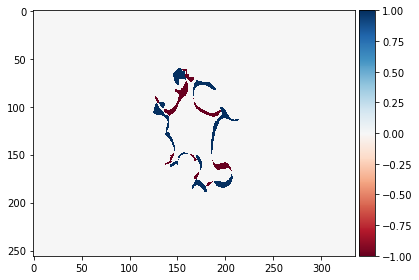

In [ ]:
itrack=0
iframe=0
movie = tracks[itrack]['movie'][0]
frame = list(tracks[itrack]['frame'])
label = list(tracks[itrack]['label'])
masks=os.listdir(masks_folder)
basename=re.findall(r"(.+)_s",masks[0])[0] 
#imshow(get_centered_cell(iframe))
difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
imshow(difference)
#print(basename,movie)

In [ ]:
cell_centered = get_centered_cell(iframe)
props = regionprops(cell_centered)
#major axis angle with respect to y (0 axis : rows) counter-clockwise -pi/2 , pi/2  
angle_y = props[0].orientation
#rotate cell so that major axis is aligned with the y axis
cell_y = rotate(cell_centered,-angle_y*180/np.pi,order=0, preserve_range=True)
#project cell on the x (1) axis
proj_x = np.sum(cell_y,1)      
#get cell polarization vector in a regular coordinate system
#skew sign corresponds to the tail of the distribution, cell polarization is  
#defined here as -skew. Because image y-axis is inverted, in a regular coordinate
#system, cell polarization vector is defined as -(-skew) = skew:
celly_polarization = [0 , skew(proj_x) ]      
#rotate back
polarization = np.dot( rotation_matrix(angle_y) , celly_polarization )
cell_angle =  np.arctan2(polarization[1],polarization[0]) 
cell_skew =skew(proj_x)

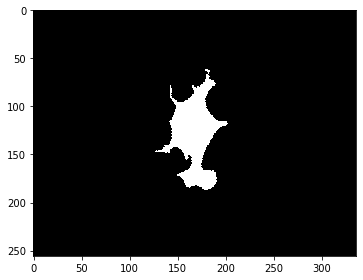

In [ ]:
imshow(cell_y)

In [ ]:
print(angle_y*180/np.pi, cell_skew, cell_angle*180/np.pi )

20.77965667091718 0.9304078082568387 110.77965667091718


In [ ]:
polarization

array([-0.33008545,  0.86988636])

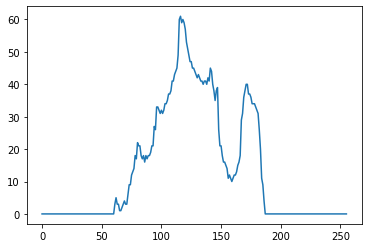

In [ ]:
plt.plot(proj_x)

In [ ]:
#PROTRUSION AND RETRACTION VECTORS : angle, norm_areas
difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
#get centroids of cell(iframe), protrusion and retraction
y,x =np.where(get_centered_cell(iframe))
centroidy, centroidx = np.median(y), np.median(x)
yp,xp = np.where(difference==1)
protrusion_y, protrusion_x  = np.median(yp) , np.median(xp)
yr,xr = np.where(difference==-1)
retraction_y, retraction_x  = np.median(yr) , np.median(xr) 
#get protr and retr angle in a regular coordinate system: [ximage , - yimage]
#and norm_areas
protrusion_angle=np.arctan2( -(protrusion_y - centroidy) , protrusion_x - centroidx) 
protrusion_norm_area=len(yp)/ len(y)
retraction_angle=np.arctan2( -(retraction_y - centroidy), retraction_x - centroidx)  
retraction_norm_area= len(yr)/len(y) 


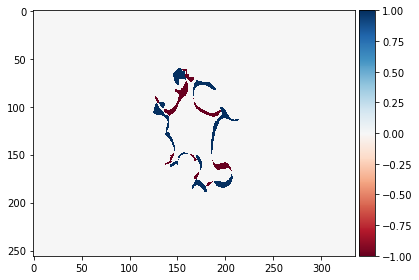

In [ ]:
difference  = get_centered_cell(iframe+1) - get_centered_cell(iframe)
imshow(difference)

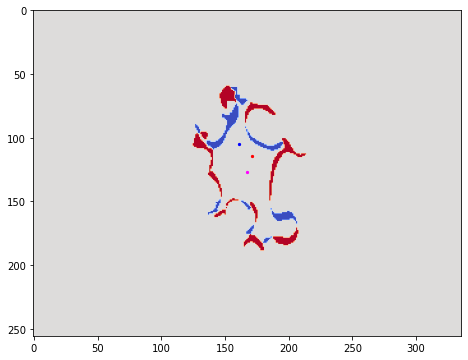

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax_image = fig.add_subplot(111) 

ax_image.imshow(difference, cmap='coolwarm')
ax_image.scatter(centroidx,centroidy,color='magenta',s=5)
ax_image.scatter(protrusion_x,protrusion_y,color='red',s=5)
ax_image.scatter(retraction_x,retraction_y,color='blue',s=5)

In [ ]:
print(protrusion_angle*180/np.pi,retraction_angle*180/np.pi )

72.89727103094764 105.25511870305778
